# 1. LOAD LIBRARY

In [1]:
# Xử lý thời gian và dữ liệu
from datetime import datetime
import pandas as pd
import numpy as np
import io
import pyreadstat

# Thống kê và phân tích
import random
from scipy.stats import (chi2, chi2_contingency, zscore, ttest_1samp, ttest_ind, levene, kstest, mannwhitneyu, ttest_rel, norm, rankdata, kruskal, pearsonr, spearmanr)
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Làm việc với Google Sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Làm việc với Excel
import xlsxwriter
from openpyxl.drawing.image import Image

# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1000)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

# 2. READ DATA

In [2]:
# File path to your file
file_path = "/Users/tanhpuh/Documents/GitHub/codev2/code/Python/Lean/Marketing Mix Modeling/Advertising Budget and Sales.csv"

# Read the data file
df = pd.read_csv(file_path)

In [3]:
df = df.rename(columns={'TV Ad Budget ($)': 'tv_ad_budget'})
df = df.rename(columns={'Radio Ad Budget ($)': 'radio_ad_budget'})
df = df.rename(columns={'Newspaper Ad Budget ($)': 'newspaper_ad_budget'})
df = df.rename(columns={'Sales ($)': 'sales'})

# 3. DESCRIPTIVE DATA

In [4]:
df.head()

,No,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   No                   200 non-null    int64  
 1   tv_ad_budget         200 non-null    float64
 2   radio_ad_budget      200 non-null    float64
 3   newspaper_ad_budget  200 non-null    float64
 4   sales                200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [6]:
df.describe()

,No,tv_ad_budget,radio_ad_budget,newspaper_ad_budget,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


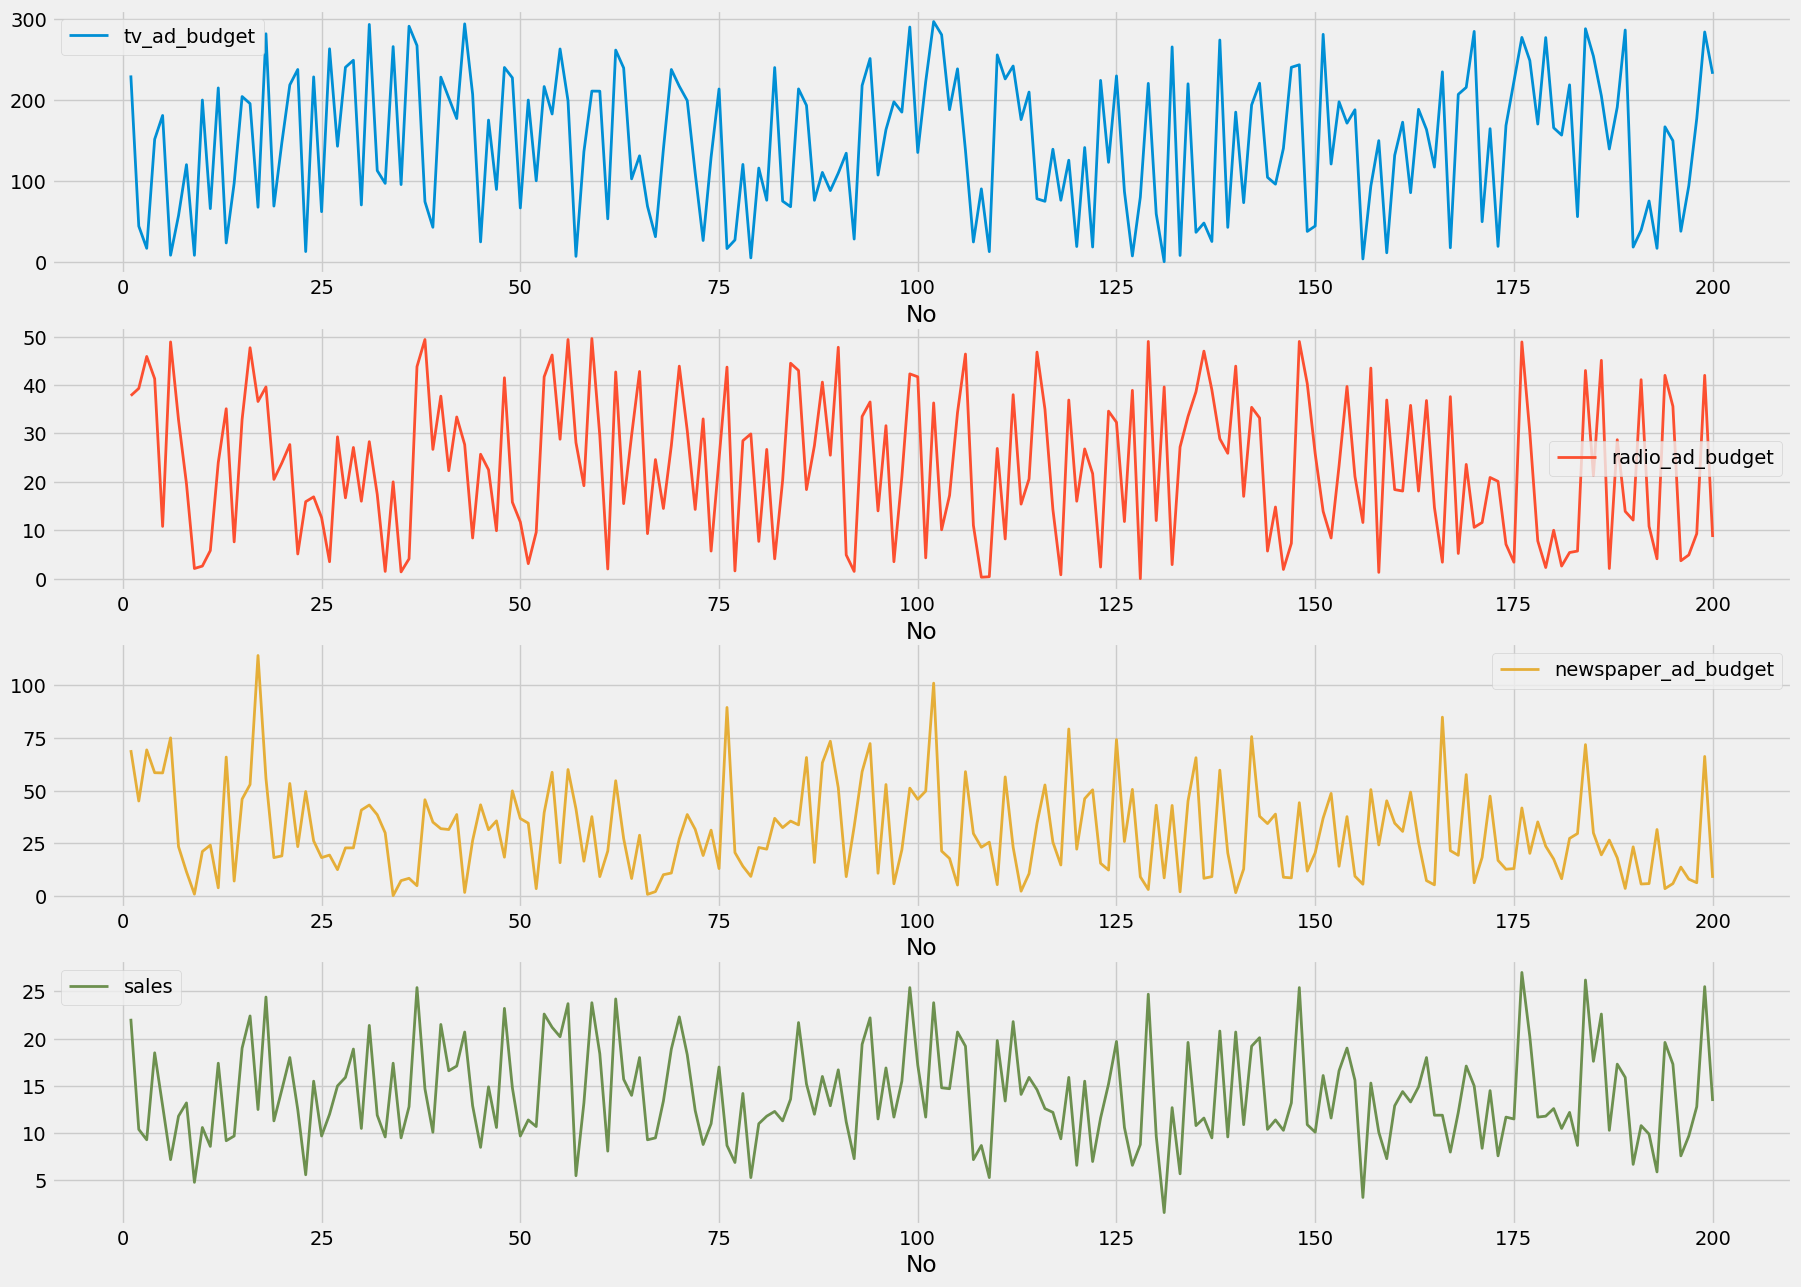

In [7]:
plt.style.use('fivethirtyeight')

df2 = df.copy('Deep')
df2 = df2.set_index('No')

# Facet plots
df2.plot(subplots=True,
        linewidth=2,
        layout=(4, 1), # 4 rows, 1 column
        figsize=(20, 15), # width 20
        sharex=False,
        sharey=False)
plt.show()

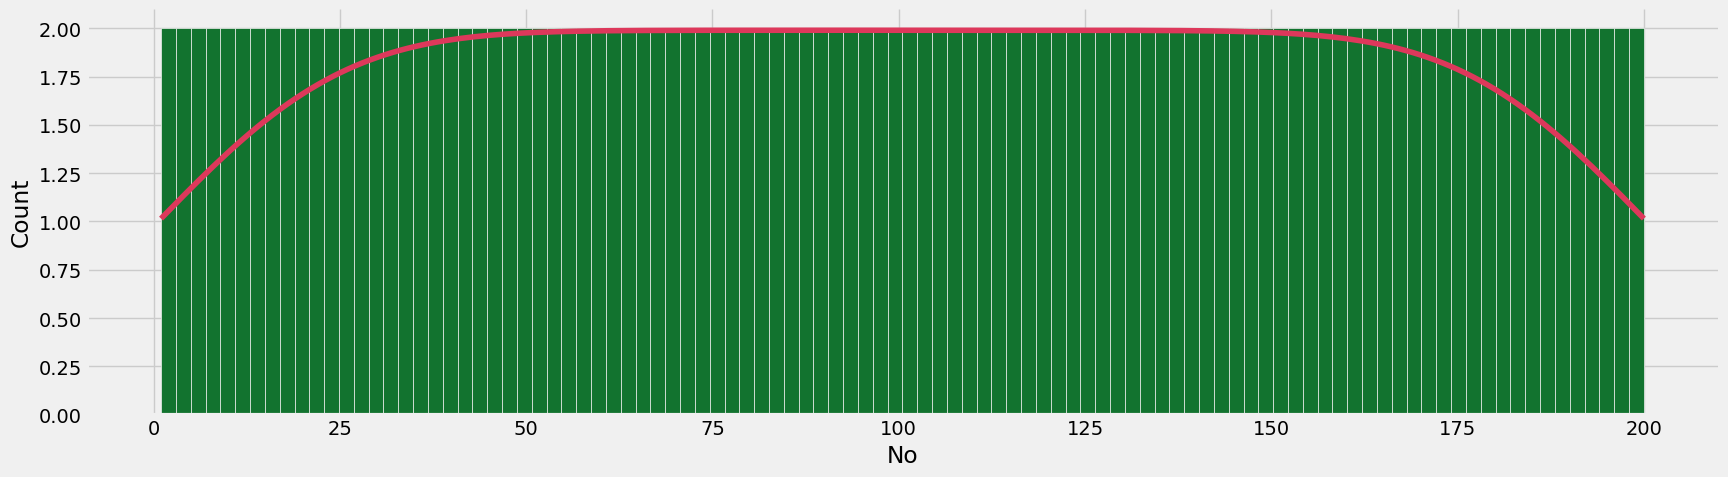

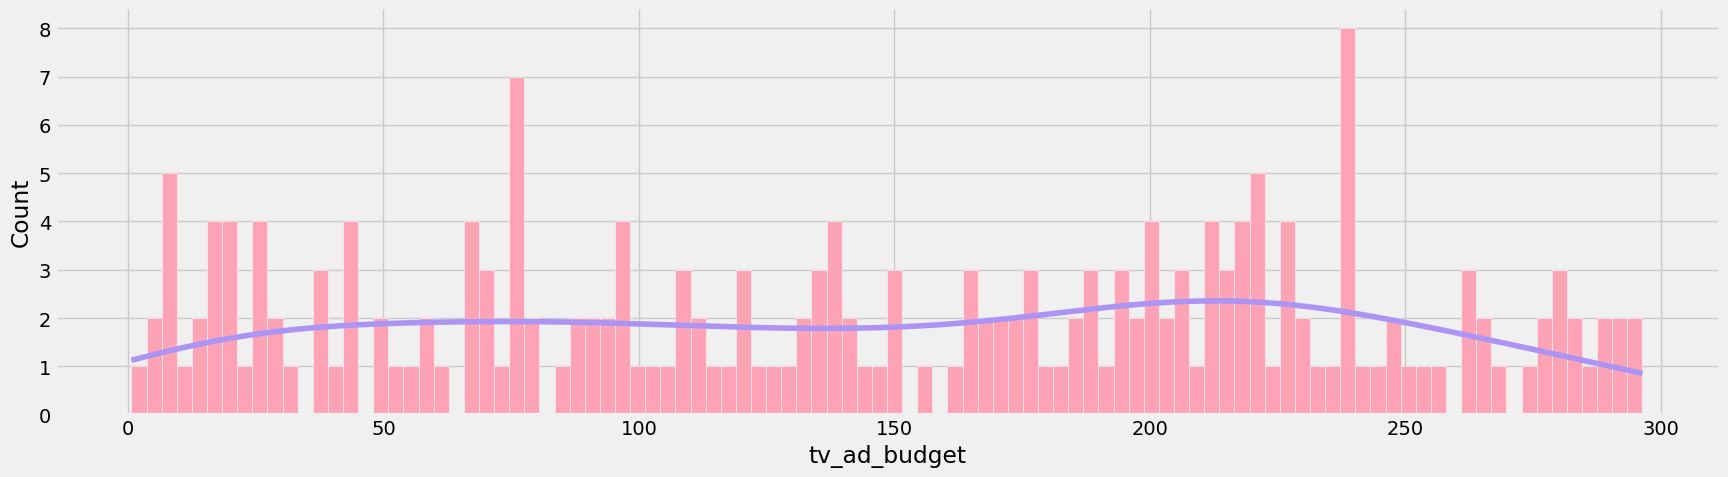

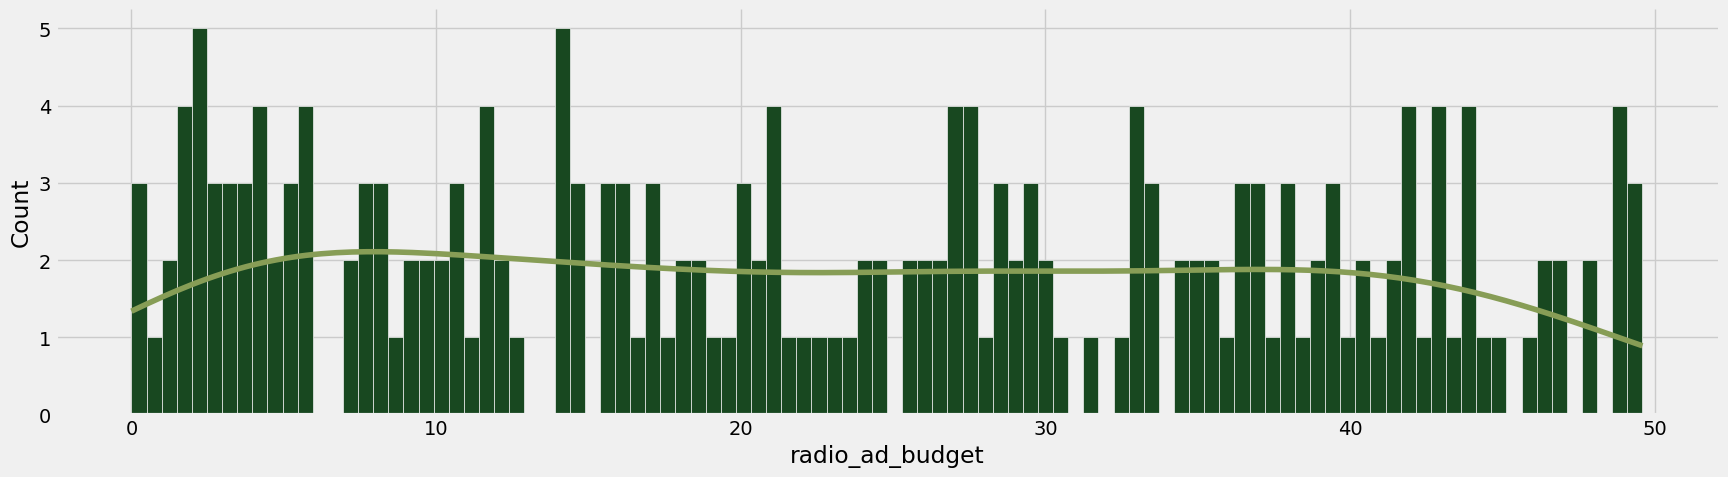

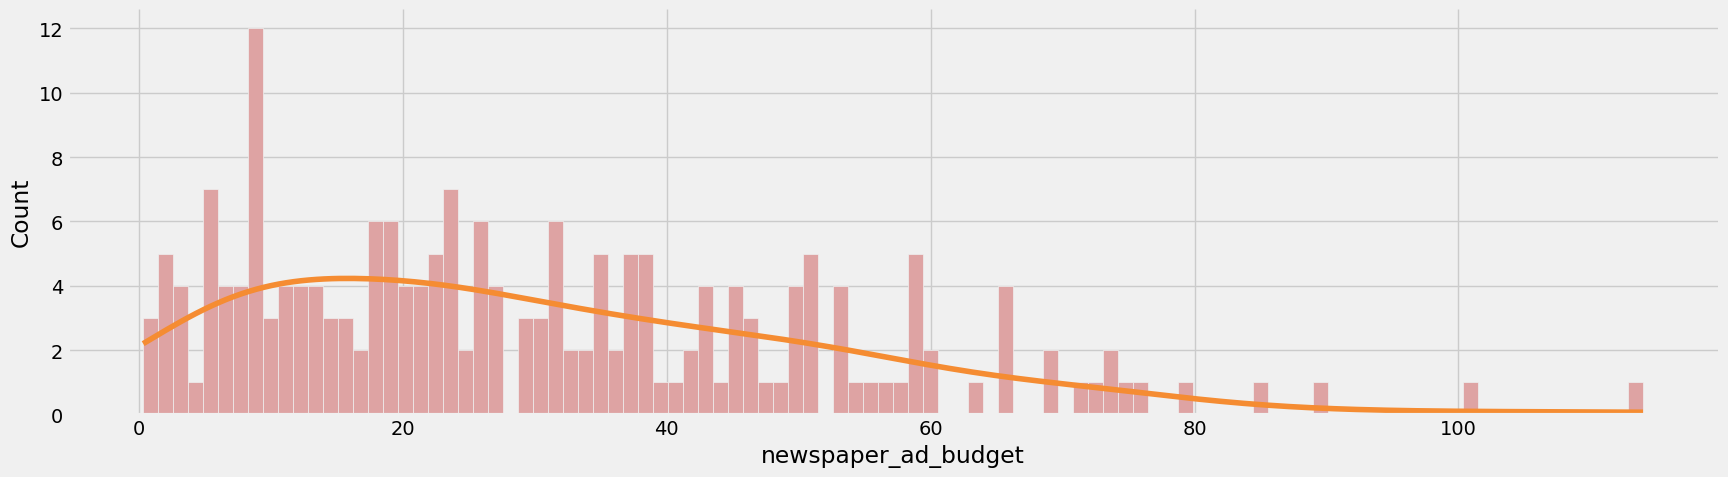

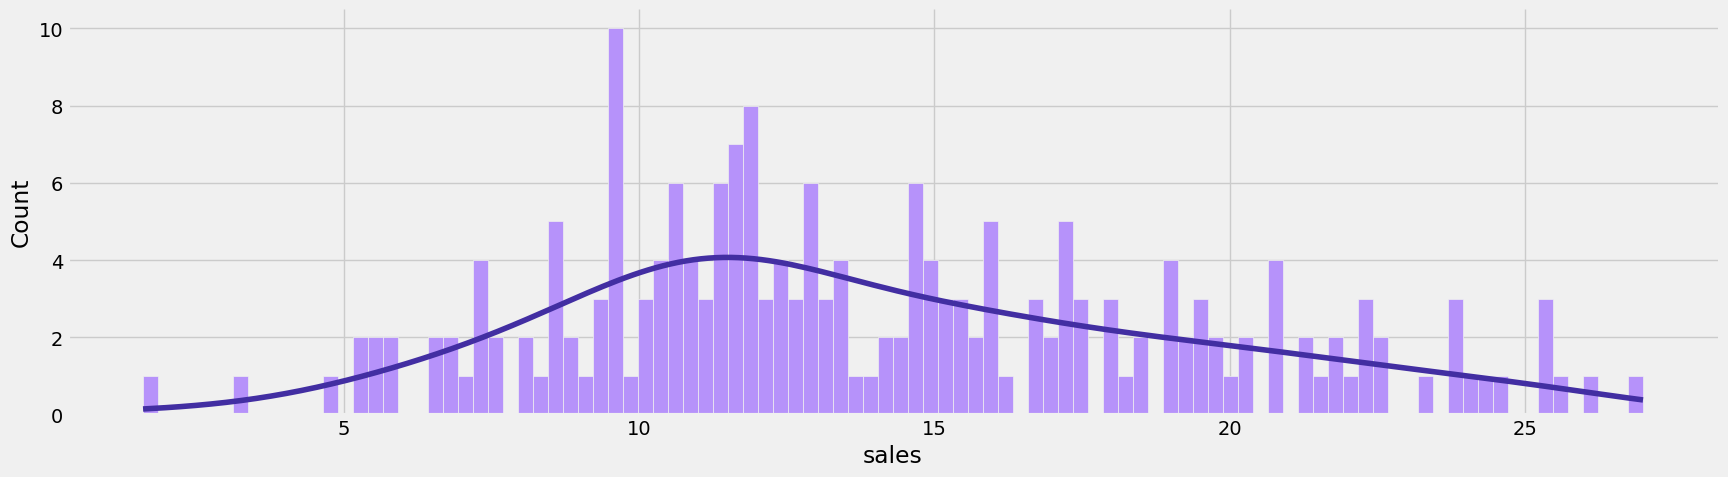

In [8]:
def random_color():
  # Generate random hex color, excluding too light colors
  while True:
    color = '#{:06x}'.format(random.randint(0, 0xFFFFFF))
    # Convert hex to RGB to check brightness
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:7], 16)
    # Skip if color is too light (using perceived brightness formula)
    if (0.299 * r + 0.587 * g + 0.114 * b) < 200:
      return color

for column_name in df.columns:
  ax1 = sns.displot(data=df, 
          x=column_name, 
          kde=True, 
          bins=100, 
          facecolor=random_color(), 
          height=5, 
          aspect=3.5,
          color=random_color())

# 4. INPUT VALUE

In [9]:
# Input Data
table = df
# Input the dependent variable
dependent_var = 'sales'

# Define the independent variables
independent_vars = table.columns.drop([dependent_var,'No']).tolist()
# Define the confidence interval
confidence_interval = 0.95
z_value = norm.ppf((1 + confidence_interval) / 2)
alpha = round(1 - confidence_interval, 3)

# 5. SCATTER PLOT FOR EACH INDEPENDENT VARIABLE

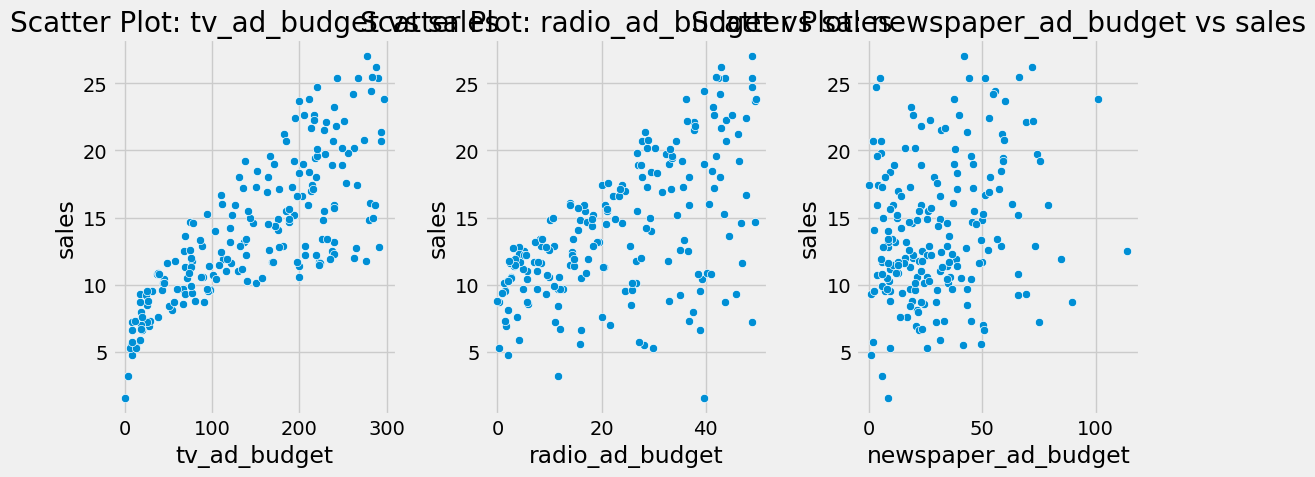

In [10]:
# Biểu đồ phân tán cho từng biến độc lập
num_plots = len(independent_vars)
cols = 4  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array for easier iteration


for i, col in enumerate(independent_vars):
    sns.scatterplot(x=col, y=dependent_var, data=table, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {col} vs {dependent_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{dependent_var}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

# 6. CORRELATION COEFFICIENT

<Axes: >

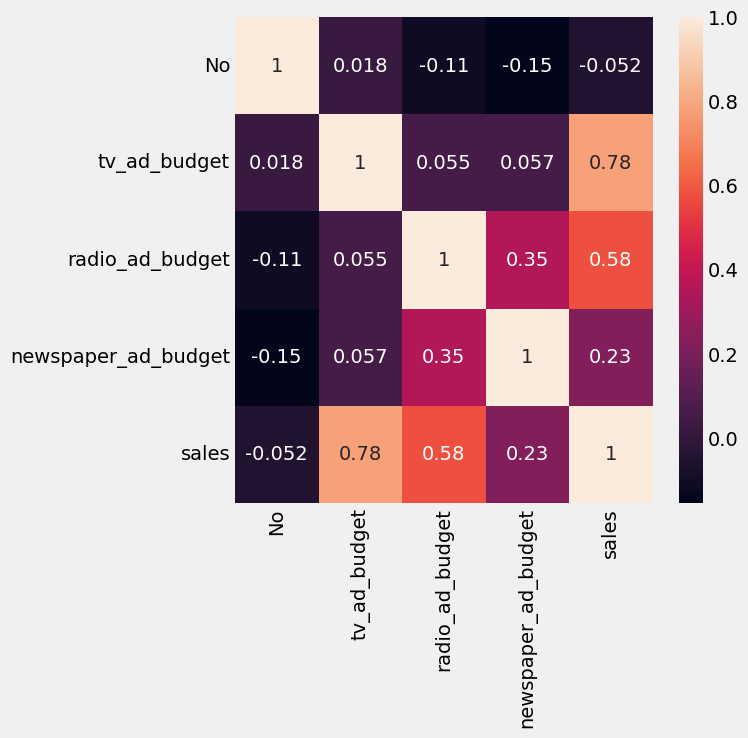

In [11]:
# Calculate the correlation matrix
correlation_matrix = table.corr()

#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(6, 6))
sns.heatmap(table.corr(), fmt='.2g', annot=True)

# 6. MULTIPLE LINEAR REGRESSION

## 6.1 TRAINING MODEL

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.58e-96
Time:                        14:25:36   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.9389    

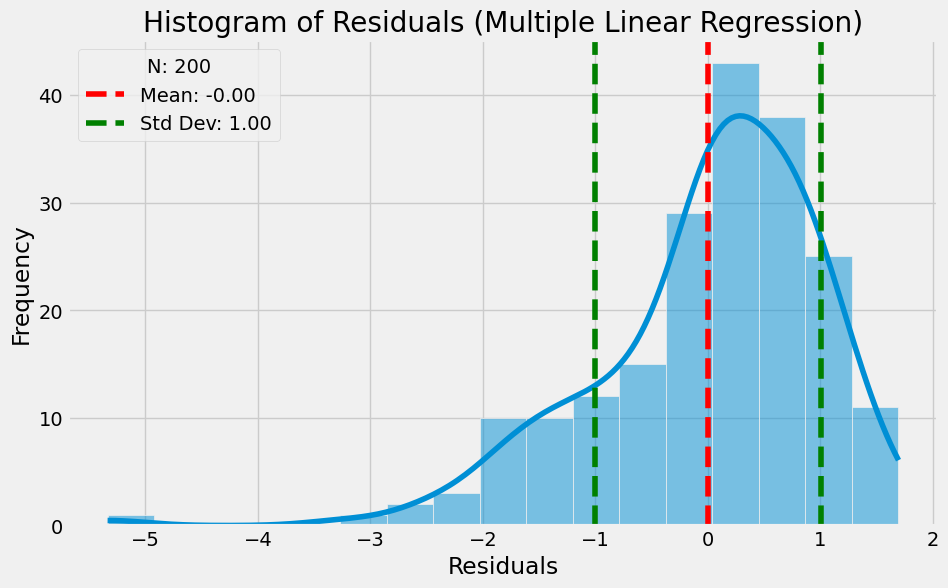

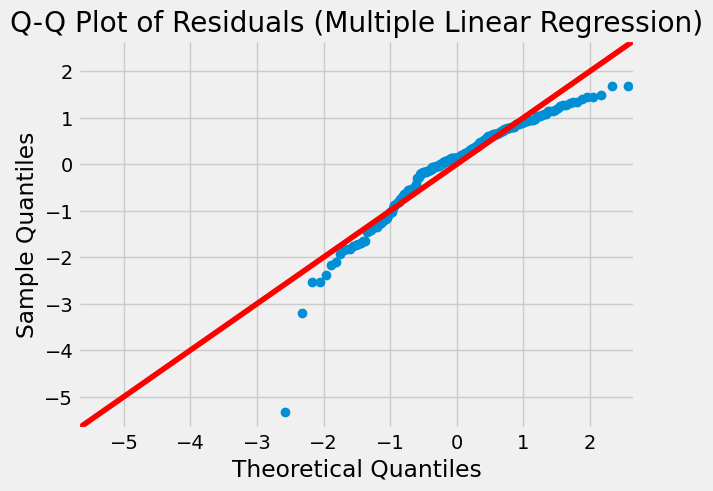

In [12]:
# Tạo mô hình hồi quy tuyến tính bội sử dụng công thức
# Create the formula for the regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the multiple linear regression model using the formula
model_multiple = smf.ols(formula, data=table).fit()
print(model_multiple.summary())
print()

# Kiểm định Durbin-Watson
residuals_multiple = model_multiple.resid
durbin_watson_multiple = sm.stats.stattools.durbin_watson(residuals_multiple)

# Redesign the model_summary table
model_summary_multiple = pd.DataFrame({
  'Date': [model_multiple.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_multiple.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_multiple.rsquared],
  'Adj. R-squared': [model_multiple.rsquared_adj],
  'Durbin Watson': [durbin_watson_multiple]
})
print('Model Summary:')
print(model_summary_multiple)
print()

# Bảng ANOVA
anova_table_multiple = sm.stats.anova_lm(model_multiple, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table[dependent_var] - table[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_multiple['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_multiple.summary().tables[0][6][1].data
df_residual = model_multiple.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_multiple.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_multiple.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_multiple = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_multiple['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_multiple)
print()

# Bảng Coefficients
coefficients_multiple = model_multiple.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_multiple.params * (table[independent_vars].std() / table[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_multiple['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars
vif_data["VIF"] = [variance_inflation_factor(table[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_multiple dataframe
coefficients_multiple = coefficients_multiple.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
coefficients_multiple = coefficients_multiple[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_multiple)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_multiple.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_multiple.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_multiple < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_multiple['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] < alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
non_significant_vars = coefficients_multiple[(coefficients_multiple['P>|t|'] >= alpha) & (coefficients_multiple['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else: 
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
print('Kiểm định t (student):')
print(result_t_test)
print()

# Check for multicollinearity using VIF
multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
if not multicollinearity_vars.empty:
  multicollinearity_result = "There is a possibility of multicollinearity"
else:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Đánh giá hiện tượng đa cộng tuyến')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_multiple.predict(table) # Prediction using model_multiple
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is relatively low, suggesting good fit.'
else:
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement.'
if rmse < 3: # example threshold, adjust as needed
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is relatively low, suggesting accurate predictions.'
else:
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement.'
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria' or 'Non-significant variables' in result_t_test:
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(conclusion)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_multiple:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')

# Viết phương trình hồi quy
intercept = coefficients_multiple.loc[coefficients_multiple['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_multiple.loc[coefficients_multiple['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.2f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.2f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.3f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_multiple = model_multiple.get_influence().resid_studentized_internal
mean_residuals_multiple = standardized_residuals_multiple.mean()
std_dev_residuals_multiple = standardized_residuals_multiple.std()
N_residuals_multiple = len(standardized_residuals_multiple)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_multiple, kde=True)
plt.title('Histogram of Residuals (Multiple Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_multiple, color='r', linestyle='--', label=f'Mean: {mean_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple + std_dev_residuals_multiple, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_multiple:.2f}')
plt.axvline(mean_residuals_multiple - std_dev_residuals_multiple, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_multiple}')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_multiple, line='45')
plt.title('Q-Q Plot of Residuals (Multiple Linear Regression)')
plt.show()

## 6.2 FORECAST

In [31]:
# Predict the values using the regression model
predicted_values = model_multiple.predict(table)

# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values

# Get the column names of independent variables from the model
independent_vars = list(model_multiple.params.index)
independent_vars.remove('Intercept')

# Construct the column list for display, dynamically adding independent variable names
columns_to_display = independent_vars + ['predicted_values']
table[columns_to_display]
print(table)

# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
new_data = pd.DataFrame({'tv_ad_budget': [300], 'radio_ad_budget': [50], 'newspaper_ad_budget': [120]})
# Predict the dependent variable value using the regression model
predicted_ttxang = model_multiple.predict(new_data)
# Display the predicted value
print(f'Predicted {dependent_var} for {independent_vars}: {predicted_ttxang.iloc[0]}')

      No  tv_ad_budget  radio_ad_budget  newspaper_ad_budget  sales  predicted_values
0      1         230.1             37.8                 69.2   22.1         20.523974
1      2          44.5             39.3                 45.1   10.4         12.337855
2      3          17.2             45.9                 69.3    9.3         12.307671
3      4         151.5             41.3                 58.5   18.5         17.597830
4      5         180.8             10.8                 58.4   12.9         13.188672
5      6           8.7             48.9                 75.0    7.2         12.478348
6      7          57.5             32.8                 23.5   11.8         11.729760
7      8         120.2             19.6                 11.6   13.2         12.122953
8      9           8.6              2.1                  1.0    4.8          3.727341
9     10         199.8              2.6                 21.2   10.6         12.550849
10    11          66.1              5.8               

# 7. NON-LINEAR REGRESSION

## 7.1 CURVE ESTIMATION

In [14]:
# Create an empty list to store the results
results = []

# Loop through each independent variable
for independent_var in independent_vars:
    # Fit different regression models
    models = {
        "Linear": f"{dependent_var} ~ {independent_var}",
        "Logarithmic": f"{dependent_var} ~ np.log({independent_var})",
        "Quadratic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2)",
        "Cubic": f"{dependent_var} ~ {independent_var} + I({independent_var}**2) + I({independent_var}**3)",
        "Power": f"np.log({dependent_var}) ~ np.log({independent_var})",  # Log-log transformation
        "Exponential": f"np.log({dependent_var}) ~ {independent_var}"  # Log transformation
    }

    for model_name, formula in models.items():
        try:
            # Fit the model
            model = smf.ols(formula, data=table).fit()

            # Extract relevant information
            rsquared = model.rsquared
            df = int(model.df_resid)  # Convert to integer
            f_statistic = model.fvalue
            p_value = model.f_pvalue
            aic = model.aic
            bic = model.bic

            # Append the results to the list
            results.append([dependent_var, independent_var, model_name, rsquared, df, f_statistic, p_value, aic, bic])

        except (ValueError, TypeError, np.linalg.LinAlgError) as e:  # Handle potential errors
            print(f"Error fitting model {model_name} for {dependent_var} ~ {independent_var}: {e}")
            # Append NaN values for the failed models
            results.append([dependent_var, independent_var, model_name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results, columns=['Dependent Var', 'Independent Vars', 'Model Name', 'rsquared', 'df', 'F Statistic', 'p_value', 'AIC', 'BIC']) # Added 'Model_Name' column
print('Curve Estimation:')
print(results_df)
print()

# Filter for significant p-values
significant_models = results_df[results_df['p_value'] <= 0.05]
# Group by 'Independent Vars' and select the row with the highest R-squared value within each group
best_models = significant_models.loc[significant_models.groupby('Independent Vars')['rsquared'].idxmax()]
print('Best Model in each Dependent Variables:')
print(best_models)

Error fitting model Logarithmic for sales ~ radio_ad_budget: SVD did not converge
Error fitting model Power for sales ~ radio_ad_budget: SVD did not converge
Curve Estimation:
   Dependent Var     Independent Vars   Model Name  rsquared     df  F Statistic       p_value          AIC          BIC
0          sales         tv_ad_budget       Linear  0.611875  198.0   312.144994  1.467390e-42  1042.091328  1048.687962
1          sales         tv_ad_budget  Logarithmic  0.565044  198.0   257.218118  1.206373e-37  1064.874988  1071.471623
2          sales         tv_ad_budget    Quadratic  0.619037  197.0   160.055372  5.211257e-42  1040.366253  1050.261205
3          sales         tv_ad_budget        Cubic  0.622002  196.0   107.506942  3.483003e-41  1040.803812  1053.997081
4          sales         tv_ad_budget        Power  0.742136  198.0   569.847528  3.505063e-60   -52.908944   -46.312310
5          sales         tv_ad_budget  Exponential  0.615599  198.0   317.086598  5.633441e-43    

/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# Create a new table to store the transformed variables
X = pd.DataFrame()

# Iterate over the best models
for index, row in best_models.iterrows():
    dependent_var = row['Dependent Var']
    independent_var = row['Independent Vars']
    model_name = row['Model Name']

    # Apply the transformation based on the best model name
    if model_name == 'Linear':
        X[f'{independent_var}'] = table[independent_var]
    elif model_name == 'Logarithmic':
        X[f'{independent_var}_log'] = np.log(table[independent_var])
    elif model_name == 'Quadratic':
        X[f'{independent_var}_qua'] = table[independent_var] ** 2
    elif model_name == 'Cubic':
        X[f'{independent_var}_cub'] = table[independent_var] ** 3
    elif model_name == 'Power':
        X[f'{independent_var}_pow'] = np.log(table[independent_var]) # Assuming this is what you intended
    elif model_name == 'Exponential':
        X[f'{independent_var}_exp'] = np.exp(table[independent_var]) # Assuming this is what you intended
    else:
        print(f"Warning: Unknown model name '{model_name}' for {independent_var}")
        X[f'{independent_var}_cu'] = table[independent_var] # Default to original value if unknown model

y = table[dependent_var]

# Concatenate X and y into a single DataFrame
combined_df = pd.concat([X, y], axis=1)

# Display the combined DataFrame
print(combined_df.head())

   newspaper_ad_budget_cub  radio_ad_budget_cub  tv_ad_budget_pow  sales
0               331373.888            54010.152          5.438514   22.1
1                91733.851            60698.457          3.795489   10.4
2               332812.557            96702.579          2.844909    9.3
3               200201.625            70444.997          5.020586   18.5
4               199176.704             1259.712          5.197391   12.9


## 7.2 STEPWISE SELECTION

In [16]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    if X.shape[1] > 1:  # Check if there are more than 1 columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        vif["VIF"] = [np.nan]  # Assign NaN if only one column is present
    return vif

# Function to perform stepwise regression
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    model_details = []  # List to store details of each regression model

    while True:
        changed = False

        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

            # Save model details
            model_details.append({
                'Features': best_features + [new_column],
                'AIC': model.aic,
                'BIC': model.bic,
                'R-squared': model.rsquared,
                'Adjusted R-squared': model.rsquared_adj
            })

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_features.append(new_pval.idxmin())
            changed = True

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)

        if not changed:
            break

    return best_features, model_details

# Perform stepwise regression
best_features, model_details = stepwise_selection(X, y)

# Print details of all regression models
print("All Models Details:")
for idx, details in enumerate(model_details, 1):
    print(f"Model {idx}:")
    print(f"Features: {details['Features']}")
    print(f"R-squared: {details['R-squared']:.4f}, Adjusted R-squared: {details['Adjusted R-squared']:.4f}") #AIC: {details['AIC']:.4f}, BIC: {details['BIC']:.4f}, 

    # Calculate VIF for the current model
    current_model_X = X[details['Features']]
    current_vif = calculate_vif(current_model_X)
    print(f"VIF for Model {idx}:")
    print(current_vif)
    print("-" * 40)
print()

# Filter for significant p-values and VIF < 10
filtered_models = []
for idx, details in enumerate(model_details):
    current_model_X = X[details["Features"]]
    current_vif = calculate_vif(current_model_X)
    
    # Check for VIF values less than 10 (excluding intercept if present)
    valid_vif = True
    if 'const' in current_vif['Variable'].values:
      current_vif = current_vif[current_vif['Variable'] != 'const']
    
    #Check if all VIF values are less than 10
    if len(current_vif) > 0 and current_vif['VIF'].max() >= 10:
        valid_vif = False
    
    if valid_vif:
        filtered_models.append(details)

# Find best model within filtered ones
best_model_filtered = None
best_r_squared = -1

for model in filtered_models:
    if model['R-squared'] > best_r_squared:
        best_r_squared = model['R-squared']
        best_model_filtered = model

print("Best Model after filtering by VIF < 10:")
if best_model_filtered:
    # print(best_model_filtered)
    #Fit the best model
    best_model = sm.OLS(y, sm.add_constant(X[best_model_filtered['Features']])).fit()
    print(best_model.summary())
    print()
    print("VIF for best model:")
    print(calculate_vif(X[best_model_filtered['Features']]))
else:
    print("No model found within VIF < 10")

All Models Details:
Model 1:
Features: ['radio_ad_budget_cub']
R-squared: 0.2867, Adjusted R-squared: 0.2831
VIF for Model 1:
              Variable  VIF
0  radio_ad_budget_cub  NaN
----------------------------------------
Model 2:
Features: ['newspaper_ad_budget_cub']
R-squared: 0.0283, Adjusted R-squared: 0.0234
VIF for Model 2:
                  Variable  VIF
0  newspaper_ad_budget_cub  NaN
----------------------------------------
Model 3:
Features: ['tv_ad_budget_pow']
R-squared: 0.5650, Adjusted R-squared: 0.5628
VIF for Model 3:
           Variable  VIF
0  tv_ad_budget_pow  NaN
----------------------------------------
Model 4:
Features: ['tv_ad_budget_pow', 'radio_ad_budget_cub']
R-squared: 0.8577, Adjusted R-squared: 0.8562
VIF for Model 4:
              Variable      VIF
0     tv_ad_budget_pow  1.62972
1  radio_ad_budget_cub  1.62972
----------------------------------------
Model 5:
Features: ['tv_ad_budget_pow', 'newspaper_ad_budget_cub']
R-squared: 0.5915, Adjusted R-squared:

## 7.3 TABLE DATA

In [17]:
independent_vars = best_model_filtered['Features'] 
dependent_var = y.name
print(dependent_var)
table_nonlinear = combined_df[[dependent_var] + independent_vars] # Use combined_df
print(table_nonlinear.head())

sales
   sales  tv_ad_budget_pow  radio_ad_budget_cub  newspaper_ad_budget_cub
0   22.1          5.438514            54010.152               331373.888
1   10.4          3.795489            60698.457                91733.851
2    9.3          2.844909            96702.579               332812.557
3   18.5          5.020586            70444.997               200201.625
4   12.9          5.197391             1259.712               199176.704


## 7.4 TRAINING MODEL

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     394.2
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           9.84e-83
Time:                        14:25:36   Log-Likelihood:                -418.62
No. Observations:                 200   AIC:                             845.2
Df Residuals:                     196   BIC:                             858.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

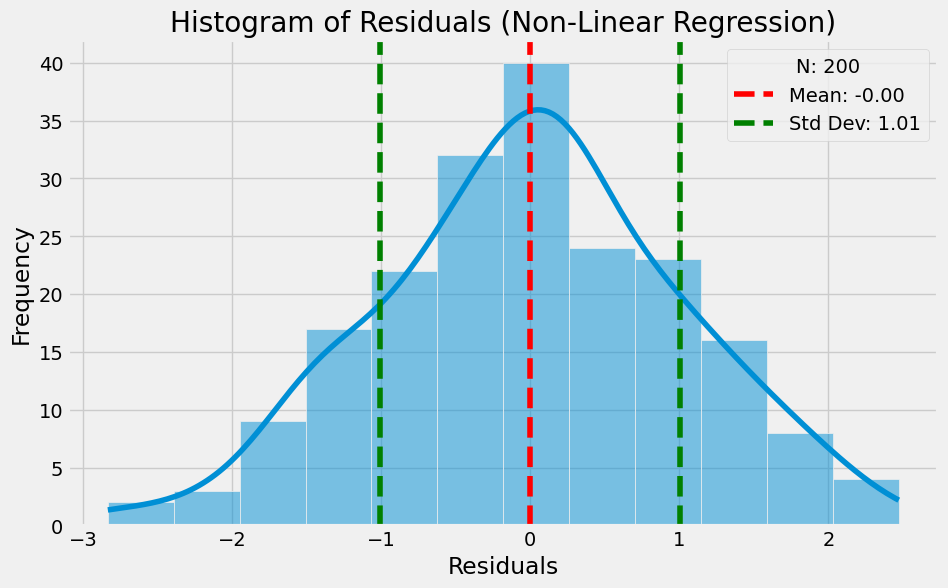

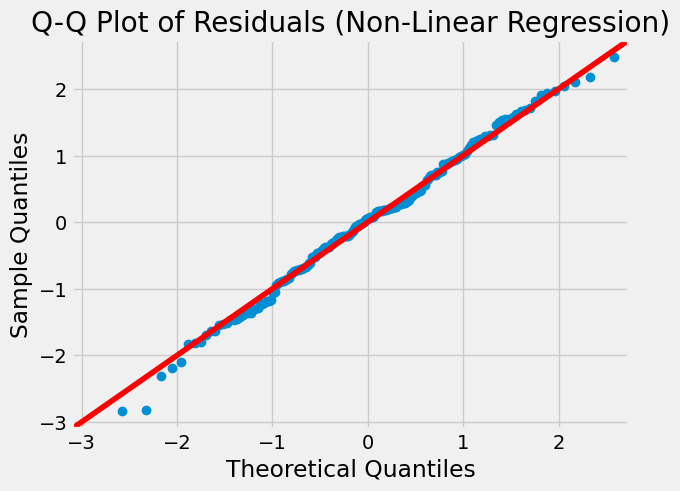

In [18]:
# Tạo mô hình hồi quy phi tuyến tính sử dụng công thức
# Create the formula for the none-linear regression model
formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
# Create the non-linear regression model using the formula
model_nonlinear_optimize = smf.ols(formula, data=table_nonlinear).fit()
print(model_nonlinear_optimize.summary())
print()

# Kiểm định Durbin-Watson
residuals_nonelinear = model_nonlinear_optimize.resid
durbin_watson_nonlinear = sm.stats.stattools.durbin_watson(residuals_nonelinear)

# Redesign the model_summary table
model_summary_nonlinear = pd.DataFrame({
  'Date': [model_nonlinear_optimize.summary2().tables[0].iloc[2, 1]],
  'Model': ['OLS'],
  'Dependent Variable': [model_nonlinear_optimize.summary2().tables[0].iloc[1, 1]],
  'R-squared': [model_nonlinear_optimize.rsquared],
  'Adj. R-squared': [model_nonlinear_optimize.rsquared_adj],
  'Durbin Watson': [durbin_watson_nonlinear]
})
print('Model Summary:')
print(model_summary_nonlinear)
print()

# Bảng ANOVA
anova_table_nonlinear = sm.stats.anova_lm(model_nonlinear_optimize, typ=2, robust='hc3')
# Calculate total sum of squares
total_sum_squares = sum((table_nonlinear[dependent_var] - table_nonlinear[dependent_var].mean())**2)
# Calculate regression sum of squares
regression_sum_squares = total_sum_squares - anova_table_nonlinear['sum_sq']['Residual']
# Degrees of freedom
df_regression = model_nonlinear_optimize.summary().tables[0][6][1].data
df_residual = model_nonlinear_optimize.summary().tables[0][7][1].data
df_total = pd.to_numeric(df_regression, errors='coerce') + pd.to_numeric(df_residual, errors='coerce')
# F-statistic and p-value
f_statistic = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][2][3].data, errors='coerce')
p_value = pd.to_numeric(model_nonlinear_optimize.summary().tables[0][3][3].data, errors='coerce')
# Create the ANOVA table
anova_table_nonlinear = pd.DataFrame({
  'Source': ['Regression', 'Residual', 'Total'],
  'sum_sq': [regression_sum_squares, anova_table_nonlinear['sum_sq']['Residual'], total_sum_squares],
  'df': [df_regression, df_residual, df_total],
  'F': [f_statistic, None, None],
  'PR(>F)': [p_value, None, None]
})
print('ANOVA Table:')
print(anova_table_nonlinear)
print()

# Bảng Coefficients
coefficients_nonlinear = model_nonlinear_optimize.summary2().tables[1]
# Calculate the standardized coefficients (beta)
standardized_coefficients = model_nonlinear_optimize.params * (table_nonlinear[independent_vars].std() / table_nonlinear[dependent_var].std())
# Add the standardized coefficients to the coefficients table
coefficients_nonlinear['Standardized Coef.'] = standardized_coefficients
# Calculate VIF for each independent variable
if len(independent_vars) == 1:
  vif_data == None
else:
  vif_data = pd.DataFrame()
  vif_data["Variable"] = independent_vars
  vif_data["VIF"] = [variance_inflation_factor(table_nonlinear[independent_vars].values, i) for i in range(len(independent_vars))]
# Add the VIP column to the coefficients_nonlinear dataframe
coefficients_nonlinear = coefficients_nonlinear.merge(vif_data, how='left', left_index=True, right_on='Variable')
# Rearrange the columns
if len(independent_vars) == 1:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]']]
else:
  coefficients_nonlinear = coefficients_nonlinear[['Variable', 'Coef.', 'Std.Err.', 'Standardized Coef.', 't', 'P>|t|', '[0.025', '0.975]', 'VIF']]
print('Coefficients:')
print(coefficients_nonlinear)
print()

# Đánh giá Adj. R-squared
adj_r_squared = model_nonlinear_optimize.rsquared_adj
adj_r_squared_result = 'Model fits well' if adj_r_squared > 0.7 else 'Model fits moderate' if 0.5 < adj_r_squared <= 0.7 else 'Model does not fit'
print('Đánh giá Adj. R-squared:')
print(adj_r_squared_result)
print()

# Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA
anova_p_value = anova_table_nonlinear.loc[0, 'PR(>F)']
anova_result = 'Model is significant' if anova_p_value < alpha else 'Model is not significant'
print('Kiểm định F - Kiểm tra Sig (p-value) bảng ANOVA:')
print(anova_result)
print()

# Kiểm định Durbin–Watson
durbin_watson_result = 'No autocorrelation' if 1.5 < durbin_watson_nonlinear < 2.5 else 'Autocorrelation present'
print('Kiểm định Durbin–Watson:')
print(durbin_watson_result)
print()

# Kiểm định t (student) - Kiểm tra Sig (p-value) từng biến độc lập bảng Coefficients
coefficients_p_values = coefficients_nonlinear['P>|t|']
# Check the significance of each independent variable excluding 'Intercept'
significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] < alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
non_significant_vars = coefficients_nonlinear[(coefficients_nonlinear['P>|t|'] >= alpha) & (coefficients_nonlinear['Variable'] != 'Intercept')]
if significant_vars is None and non_significant_vars is not None:
  result_t_test = f"Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
elif significant_vars is not None and non_significant_vars is None:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())}"
else:
  result_t_test = f"Significant variables: {', '.join(significant_vars['Variable'].dropna())} AND Non-significant variables: {', '.join(non_significant_vars['Variable'].dropna())}"
# Check for multicollinearity using VIF
if len(independent_vars) == 1:
  multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
else:
  multicollinearity_vars = vif_data[vif_data['VIF'] > 10]
  if not multicollinearity_vars.empty:
    multicollinearity_result = "There is a possibility of multicollinearity"
  else:
    multicollinearity_result = "The model is suitable as all variables meet the VIF criteria"
print('Kiểm định t (student)')
print(multicollinearity_result)
print()

# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear) # Prediction using model_nonlinear
# Add the predicted values to the dataframe
table['predicted_values'] = predicted_values # Adding the column to 'table'
# Calculate MSE using NumPy
mse = np.mean((table[dependent_var] - table['predicted_values'])**2)
# Calculate RMSE
rmse = np.sqrt(mse)
# Evaluate MSE and RMSE
if mse < 10 : # example threshold, adjust as needed
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is relatively low, suggesting good fit.'
else:
  mse = f'mse = {mse}. The model\'s Mean Squared Error (MSE) is high, indicating poor fit. Consider model improvement.'
if rmse < 3: # example threshold, adjust as needed
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is relatively low, suggesting accurate predictions.'
else:
  rmse = f'mse = {rmse}. The model\'s Root Mean Squared Error is high, suggesting inaccurate predictions. Consider model improvement.'
print('Đánh giá MSE và RMSE:')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print()

# Kiểm tra nếu có điểm nào không đạt yêu cầu
if adj_r_squared_result != 'Model fits well' or anova_result != 'Model is significant' or durbin_watson_result != 'No autocorrelation' or multicollinearity_result != 'The model is suitable as all variables meet the VIF criteria':
  conclusion = "Should Optimized Model"
else:
  conclusion = "Model Meets Requirements"
print('Đánh giá tổng hợp:')
print(multicollinearity_result)
print()

# Tạo bảng hypothesis_test
hypothesis_test = pd.DataFrame({
  'Đánh giá Adj. R-squared': [f'Adjusted R-squared: {adj_r_squared:.3f}, Result: {adj_r_squared_result}'],
  'Kiểm định F': [f'ANOVA p-value: {anova_p_value:.3e}, Result: {anova_result}'],
  'Kiểm định t (student)': [result_t_test],
  'Kiểm định Durbin-Watson': [f'Durbin-Watson: {durbin_watson_nonlinear:.3f}, Result: {durbin_watson_result}'],
  'Kiểm định VIP': [multicollinearity_result],
  'mse': [mse],
  'rmse': [rmse],
  'Conclusion': [conclusion]
})
hypothesis_test = hypothesis_test.melt(var_name='Test', value_name='Result')
print('Hypothsis Test:')
print(hypothesis_test)
print()

# Viết phương trình hồi quy
intercept = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] == 'Intercept', 'Coef.'].values[0]
slopes = coefficients_nonlinear.loc[coefficients_nonlinear['Variable'] != 'Intercept', ['Variable', 'Coef.']]
regression_equation = f'y = {intercept:.2f}'
for index, row in slopes.iterrows():
  regression_equation += f' + {row["Coef."]:.6f} * {row["Variable"]}'
  regression_equation = f'y = {intercept:.6f}'
  for index, row in slopes.iterrows():
    coef = row["Coef."]
    variable = row["Variable"]
    sign = '+' if coef >= 0 else '-'
    regression_equation += f' {sign} {abs(coef):.6f} * {variable}'
print('Regression Equation:')
print(regression_equation)
print()

# Tạo bảng phương trình hồi quy
regression_equation_df = pd.DataFrame({
  'Function': [regression_equation],
  'Conclusion': [conclusion]
})

# Biểu đồ Histogram để khảo sát phân phối của phần dư
standardized_residuals_nonelinear = model_nonlinear_optimize.get_influence().resid_studentized_internal
mean_residuals_nonelinear = standardized_residuals_nonelinear.mean()
std_dev_residuals_nonelinear = standardized_residuals_nonelinear.std()
N_residuals_nonelinear = len(standardized_residuals_nonelinear)
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals_nonelinear, kde=True)
plt.title('Histogram of Residuals (Non-Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(mean_residuals_nonelinear, color='r', linestyle='--', label=f'Mean: {mean_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear + std_dev_residuals_nonelinear, color='g', linestyle='--', label=f'Std Dev: {std_dev_residuals_nonelinear:.2f}')
plt.axvline(mean_residuals_nonelinear - std_dev_residuals_nonelinear, color='g', linestyle='--')
plt.legend(title=f'N: {N_residuals_nonelinear}')
plt.show()
print()

# Biểu đồ Q-Q plot để khảo sát phân phối của phần dư
sm.qqplot(standardized_residuals_nonelinear, line='45')
plt.title('Q-Q Plot of Residuals (Non-Linear Regression)')
plt.show()
print()

## 7.5 FORECAST

In [19]:
# Predict the values using the regression model
predicted_values = model_nonlinear_optimize.predict(table_nonlinear)

# Add the predicted values to the dataframe
table_nonlinear['predicted_values'] = predicted_values

# Display the dataframe with the predicted values
print(table_nonlinear)

     sales  tv_ad_budget_pow  radio_ad_budget_cub  newspaper_ad_budget_cub  predicted_values
0     22.1          5.438514            54010.152               331373.888         19.243548
1     10.4          3.795489            60698.457                91733.851         13.252983
2      9.3          2.844909            96702.579               332812.557         12.573380
3     18.5          5.020586            70444.997               200201.625         18.898854
4     12.9          5.197391             1259.712               199176.704         13.922136
5      7.2          2.163323           116930.169               421875.000         11.594409
6     11.8          4.051785            35287.552                12977.875         12.143823
7     13.2          4.789157             7529.536                 1560.896         12.755697
8      4.8          2.151762                9.261                    1.000          1.797830
9     10.6          5.297317               17.576                 9528

/var/folders/90/0lwzz7y107b9zlcpf99xnks80000gn/T/ipykernel_50899/1294708865.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_nonlinear['predicted_values'] = predicted_values


In [32]:
# Example prediction for new data
# Define the value of independent variables for which you want to predict the dependent variable
tv_ad_budget_value = 300
radio_ad_budget_value = 50
newspaper_ad_budget_value = 120

new_data = pd.DataFrame({
    'tv_ad_budget_pow': [np.log(tv_ad_budget_value)],
    'radio_ad_budget_cub': [(radio_ad_budget_value)** 3],
    'newspaper_ad_budget_cub': [(newspaper_ad_budget_value)** 3]
})
# Predict the dependent variable value using the regression model
predicted_values = model_nonlinear_optimize.predict(new_data)

# Display the predicted value
print(f'Predicted {dependent_var}: {predicted_values.iloc[0]}')

Predicted sales: 26.663529689994178
